In [61]:
from skimage import img_as_float
import matplotlib.pyplot as plt
import numpy as np

def imshow_all(*images, titles=None):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 10
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
        ax.set_title(label)

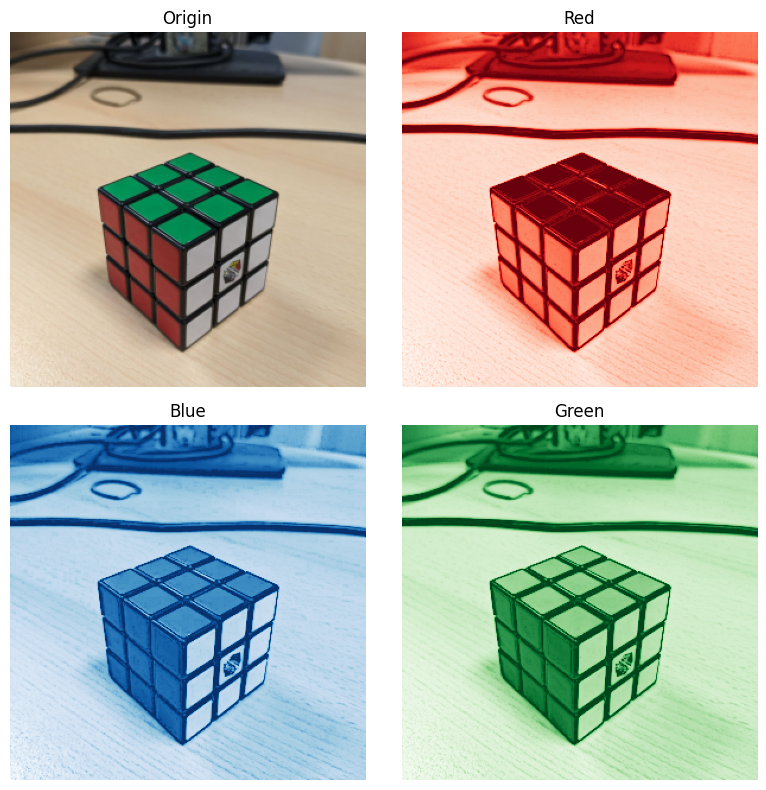

In [62]:
import cv2

import random as rng
from scipy import ndimage as ndi

# crop image to have a square image
def crop_square(img, size, interpolation=cv2.INTER_AREA):
    h, w = img.shape[:2]
    min_size = np.amin([h,w])

    # Centralize and crop
    crop_img = img[int(h/2-min_size/2):int(h/2+min_size/2), int(w/2-min_size/2):int(w/2+min_size/2)]
    resized = cv2.resize(crop_img, (size, size), interpolation=interpolation)

    return resized

input_image = crop_square(cv2.imread('images/real_cube8.jpeg'), 300)

black_back_image = 255 - input_image

blue, green, red = cv2.split(black_back_image)

# high pass per il colore rosso -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(red, (9,9), 0)
high_pass = cv2.subtract(red, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale rossa
red = cv2.add(red, high_pass)

# high pass per il colore blu -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(blue, (9,9), 0)
high_pass = cv2.subtract(blue, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale blu
blue = cv2.add(blue, high_pass)

# high pass per il colore verde -> evidenziazione dei bordi della immagine 
blur = cv2.GaussianBlur(green, (9,9), 0)
high_pass = cv2.subtract(green, blur)
high_pass = cv2.convertScaleAbs(high_pass, alpha = 3.0)
# combinazione high pass con l'immagine originale verde
green = cv2.add(green, high_pass)


plt.figure(figsize=(8, 8))

# Prima immagine
plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB))
plt.title('Origin')
plt.axis('off')

# Seconda immagine
plt.subplot(2, 2, 2)
plt.imshow(red, cmap='Reds')
plt.title('Red')
plt.axis('off')

# Terza immagine
plt.subplot(2, 2, 3)
plt.imshow(blue, cmap='Blues')
plt.title('Blue')
plt.axis('off')

# Quarta immagine
plt.subplot(2, 2, 4)
plt.imshow(green, cmap='Greens')
plt.title('Green')
plt.axis('off')

plt.tight_layout()  # Aggiunge spaziatura tra le immagini per una migliore visualizzazione
plt.show()

In [63]:
# Unione dei colori
from skimage.morphology import square
from skimage import filters

HP_gray_image = 255 - cv2.cvtColor(cv2.merge([blue, green, red],), cv2.COLOR_BGR2GRAY) # immagine High Pass in B/W
#plt.imshow(HP_gray_image,cmap="gray")

In [64]:
#effettuo treshold dinamico per evidenziare i bordi del cubo
adaptive_gaussian = cv2.adaptiveThreshold(HP_gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 7, 7) 

In [65]:
# resize del cubo dato che avere una grandezza eccessiva della imamgine può confondere i step successivi
# Anche perchè così le irregolarità dei bordi vengono smussati
resized = cv2.resize(adaptive_gaussian, (300, 300), interpolation = cv2.INTER_AREA)

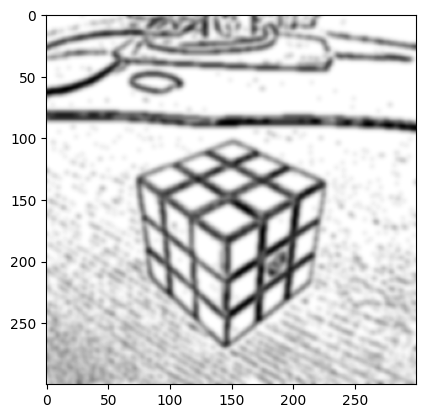

In [66]:
# altro step per smussare, dopo lo step precedente di resize
smooth = filters.gaussian(resized, sigma=2)
plt.imshow(smooth,cmap="gray")

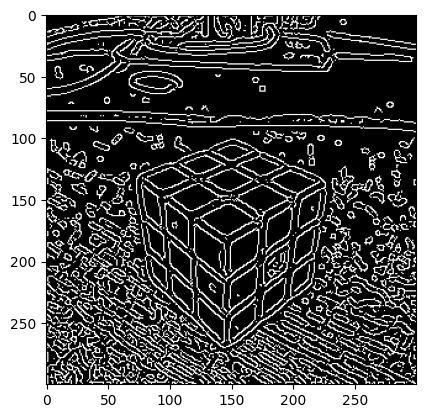

In [67]:
# effettuo canny, dato che la threshold non ha dei valori 0/255 ma DA 0 A 255, che non sono ottimali per gli step successivi
smooth *= 255/smooth.max() 
smooth = np.array(smooth, np.uint8)


lower = 10
upper = lower*3
canny = cv2.Canny(smooth,lower,upper)
plt.imshow(canny,cmap="gray")

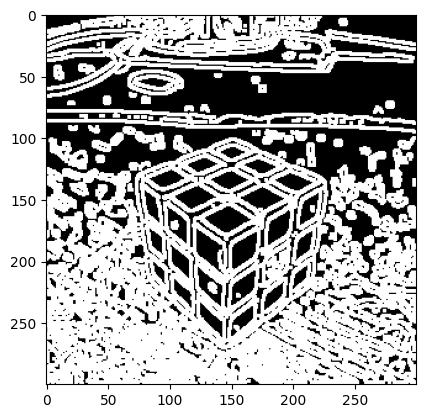

In [68]:
# grazie al fatto che abbiamo solo 0 oppure solo 1, possiamo pocedere a dilatare, per rimpire buchi che possono esserci

kernel = np.ones((3,3),np.uint8)
dilatated = cv2.dilate(canny,kernel,iterations = 1)
plt.imshow(dilatated,cmap="gray")

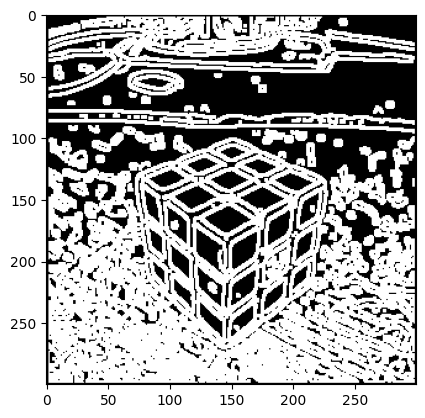

In [69]:
# diamo per scontato che ci possono essere delle linee orizzontali, quindi del rumore nel background
# per fare in modo di rimoverlo, creiamo uno cornice nera intorno alla immagine (se non c'è noise allora non è visibile)

thickness = 2

cv2.line(dilatated, (0,0), (0,300), (0,0,0), thickness)
cv2.line(dilatated, (0,300), (300,300), (0,0,0), thickness)
cv2.line(dilatated, (300,300), (300,0), (0,0,0), thickness)
cv2.line(dilatated, (300,0), (0,0), (0,0,0), thickness)

plt.imshow(dilatated,cmap="gray")

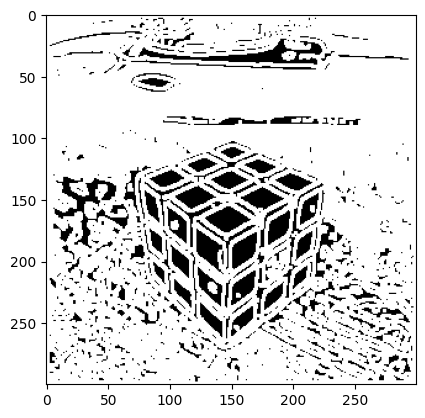

In [70]:
# facciamo un fill per rimuovere noise nel background, partendo dalla cornice nera creata precedentemente
# proprio grazia alla cornice, partendo da un solo punto, possiamo rimepire da tutto il bordo!

seed_point = (0, 0)
new_color = (255,255,255)

cv2.floodFill(dilatated, None, seed_point, new_color)

plt.imshow(dilatated,cmap="gray")

In [71]:

'''contours, _ = cv2.findContours(255-dilatated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 10
filtered_image = np.zeros_like(dilatated)
for contour in contours:
    area = cv2.contourArea(contour)
    if area >= min_area:
        cv2.drawContours(filtered_image, [contour], -1, 255, thickness=cv2.FILLED)

plt.imshow(filtered_image,cmap="gray")'''

'contours, _ = cv2.findContours(255-dilatated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)\nmin_area = 10\nfiltered_image = np.zeros_like(dilatated)\nfor contour in contours:\n    area = cv2.contourArea(contour)\n    if area >= min_area:\n        cv2.drawContours(filtered_image, [contour], -1, 255, thickness=cv2.FILLED)\n\nplt.imshow(filtered_image,cmap="gray")'

In [72]:
new_width, new_height = 500, 500

x_offset = (new_width - dilatated.shape[1]) // 2
y_offset = (new_height - dilatated.shape[0]) // 2

increased_dilatated = np.zeros((new_height, new_width), dtype=np.uint8)
increased_dilatated = 255 - increased_dilatated

increased_dilatated[y_offset:y_offset + dilatated.shape[0], x_offset:x_offset + dilatated.shape[1]] = dilatated

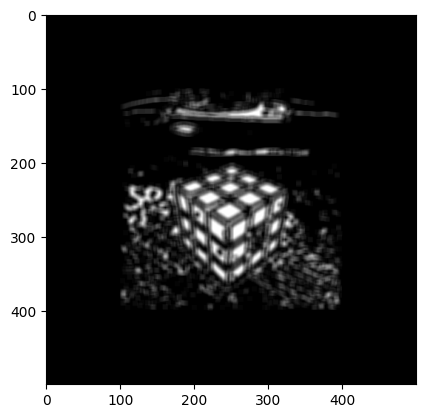

In [73]:
# effettuato mean kernel per cercare di smussare eventuale noise, e rimpire anche i buchi

mean_kernel = np.full((7, 7), 1/49)
mean = ndi.correlate(255 - increased_dilatated, mean_kernel)
plt.imshow(mean,cmap="gray")

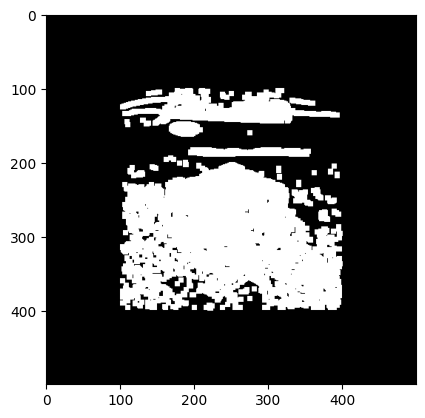

In [74]:
# effettuiamo threshold, portando a 255 tutto ciò che non è totalmente nero (si si vede che grazie allo smussamento molti buchi vengono riempiti)
ret,thresh = cv2.threshold(mean,1,255,cv2.THRESH_BINARY)
plt.imshow(thresh,cmap="gray")

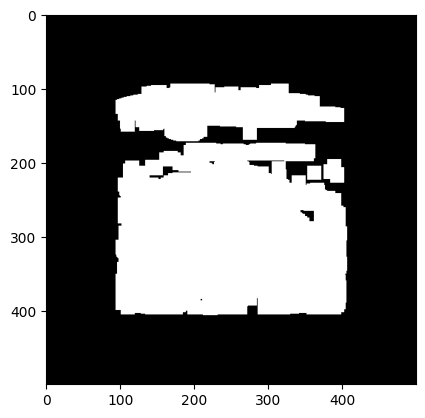

In [75]:
# espandiamo il colore bianco, per cercare di riempire i buchi, non solo all'interno ma anche sul bordo

kernel = np.ones((5,5),np.uint8)
erosion = cv2.dilate(thresh,kernel,iterations = 3)
plt.imshow(erosion,cmap="gray")

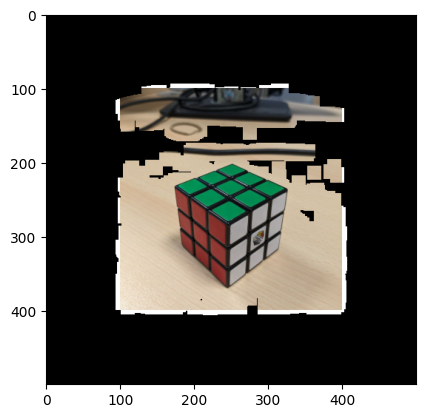

In [76]:
smaller_input_image = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
x_offset = (new_width - smaller_input_image.shape[1]) // 2
y_offset = (new_height - smaller_input_image.shape[0]) // 2

tmp = np.zeros((new_height, new_width, 3), dtype=np.uint8)
tmp = 255 - tmp
tmp[y_offset:y_offset + smaller_input_image.shape[0], x_offset:x_offset + smaller_input_image.shape[1]] = smaller_input_image

result_image = cv2.bitwise_and(tmp, tmp, mask=erosion)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))

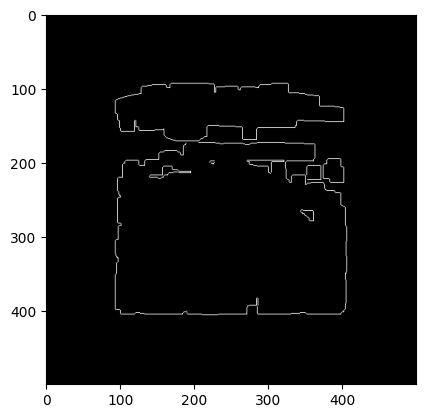

In [77]:
# trovato bordo del cubo di rubik
edges = cv2.Canny(erosion, 50, 150)
plt.imshow(edges,cmap="gray")

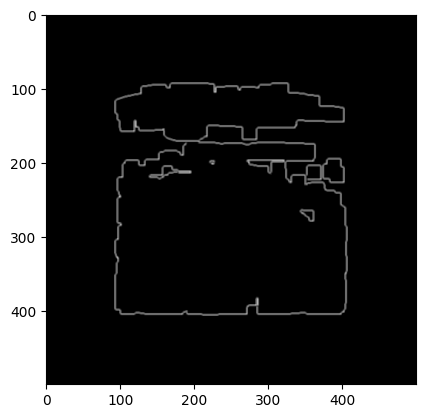

In [78]:
# dato che il borso è estremamente pieno di rumore, effettuo smussamento per cercare di renderlo più una liena, anzichè un continuo alto/basso
mean_kernel = np.full((3, 3), 1/9)
edges = ndi.correlate(edges, mean_kernel)
plt.imshow(edges,cmap="gray")

In [79]:
'''
all_images = []
titles = []
c=5
plt.figure(figsize=(8, 8))
for i in np.arange(1, 10, 0.5):
    lines = cv2.HoughLinesP(edges, 3, np.pi/180, threshold=30, minLineLength=60, maxLineGap=60)
    image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
    
    all_images.append()

images = [img_as_float(img) for img in all_images]
vmin = min(map(np.min, images))
vmax = max(map(np.max, images))
ncols = len(images)
height = 10
width = height * len(images)
fig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))
for ax, img, label in zip(axes.ravel(), images, titles):
    ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")
    ax.set_title(label)'''

'\nall_images = []\ntitles = []\nc=5\nplt.figure(figsize=(8, 8))\nfor i in np.arange(1, 10, 0.5):\n    lines = cv2.HoughLinesP(edges, 3, np.pi/180, threshold=30, minLineLength=60, maxLineGap=60)\n    image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)\n    for line in lines:\n        x1, y1, x2, y2 = line[0]\n        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)\n    \n    all_images.append()\n\nimages = [img_as_float(img) for img in all_images]\nvmin = min(map(np.min, images))\nvmax = max(map(np.max, images))\nncols = len(images)\nheight = 10\nwidth = height * len(images)\nfig, axes = plt.subplots(nrows=1, ncols=ncols,figsize=(width, height))\nfor ax, img, label in zip(axes.ravel(), images, titles):\n    ax.imshow(img, vmin=vmin, vmax=vmax,cmap="gray")\n    ax.set_title(label)'

In [80]:
'''
import ipywidgets as widgets

lines = []

@widgets.interact(x=(1, 10),y=(1, 360*2),z=(1, 30*4))
def f(x=3,y=180,z=30):
    lines = cv2.HoughLinesP(edges, x, np.pi/y, threshold=30, minLineLength=60, maxLineGap=z)

    # Disegna le linee sull'immagine originale per visualizzazione
    image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
    plt.imshow(image_with_lines,cmap="gray")

'''

'\nimport ipywidgets as widgets\n\nlines = []\n\n@widgets.interact(x=(1, 10),y=(1, 360*2),z=(1, 30*4))\ndef f(x=3,y=180,z=30):\n    lines = cv2.HoughLinesP(edges, x, np.pi/y, threshold=30, minLineLength=60, maxLineGap=z)\n\n    # Disegna le linee sull\'immagine originale per visualizzazione\n    image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)\n    for line in lines:\n        x1, y1, x2, y2 = line[0]\n        cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)\n    plt.imshow(image_with_lines,cmap="gray")\n\n'

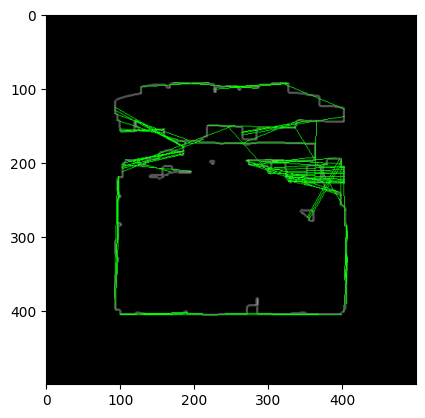

In [81]:
# dato che le linee del bordo trovate finora sono anche piene di noise, nonostante lo smussamento, uso una funzione che data una forma, si ricava delle linee DRITTE

lines = cv2.HoughLinesP(edges, 3, np.pi/200, threshold=30, minLineLength=60, maxLineGap=30)

# Disegna le linee sull'immagine originale per visualizzazione
image_with_lines = image_with_lines = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(image_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 1)
plt.imshow(image_with_lines,cmap="gray")

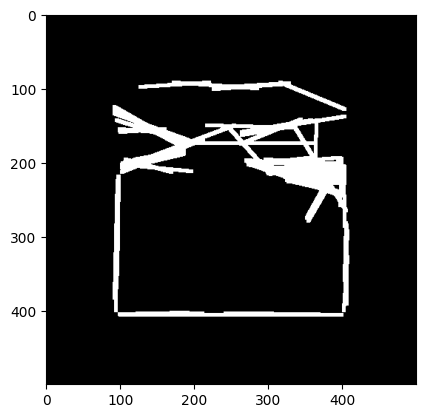

In [82]:
# 

void = np.zeros_like(erosion)
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(void, (x1, y1), (x2, y2), 255, 1)
void = cv2.dilate(void,kernel,iterations = 1)
plt.imshow(void,cmap="gray")

In [83]:
def extract_shape(border):
    contours = []
    kernel = np.ones((5,5),np.uint8)
    seed_point = (0, 0)
    new_color = (255,255,255)

    loops=0

    while(not len(contours)==1):
        loops+=1
        border = cv2.dilate(border,kernel,iterations = 1)

        void2 = border.copy()
        cv2.floodFill(void2, None, seed_point, new_color)

        contours, _ = cv2.findContours(255-void2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    
    return contours, loops

5


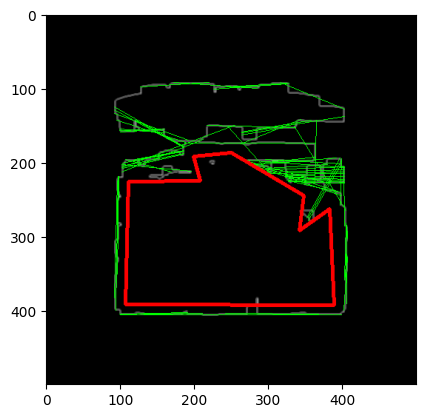

In [84]:
contours, loops = extract_shape(void)

print(loops)
epsilon = 0.02 * cv2.arcLength(contours[0], True)
approx_polygon = cv2.approxPolyDP(contours[0], epsilon, True)

tmp = cv2.cvtColor(np.zeros_like(void),cv2.COLOR_GRAY2RGB)
cv2.drawContours(image_with_lines, [approx_polygon], -1, (0,0,255), thickness = 3)
plt.imshow(cv2.cvtColor(image_with_lines, cv2.COLOR_BGR2RGB))

43 vs 56


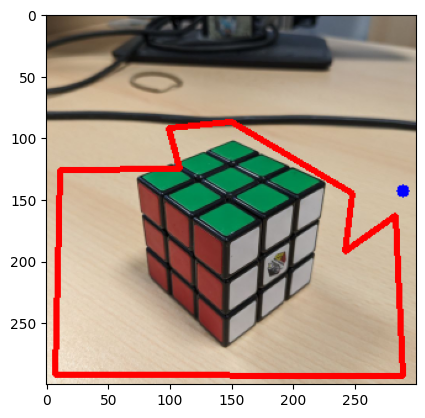

In [85]:
decreased_polygon = approx_polygon - 100
decreased_polygon = np.round(decreased_polygon).astype(np.int32)

sorted_vertices = sorted(decreased_polygon, key=lambda point: point[0][1])

tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
cv2.drawContours(tmp, [decreased_polygon], -1, (0, 0, 255), thickness = 3)

DX1=DX2=SX1=SX2=0
if(sorted_vertices[1][0][0] > sorted_vertices[2][0][0]):
    DX1 = sorted_vertices[1][0]
    SX1 = sorted_vertices[2][0]
else:
    DX1 = sorted_vertices[2][0]
    SX1 = sorted_vertices[1][0]
if(sorted_vertices[3][0][0] > sorted_vertices[4][0][0]):
    DX2 = sorted_vertices[3][0]
    SX2 = sorted_vertices[4][0]
else:
    DX2 = sorted_vertices[4][0]
    SX2 = sorted_vertices[3][0]

prospettiva = (sorted_vertices[1][0][1]-sorted_vertices[0][0][1])+(sorted_vertices[2][0][1]-sorted_vertices[0][0][1])

lowest_vertex = sorted_vertices[-1][0]

center = (lowest_vertex[0], sorted_vertices[0][0][1] + int(np.exp(prospettiva/90)*35))
print(str(prospettiva)+ " vs "+str(int(np.exp(prospettiva/90)*35)))

cv2.circle(tmp, center, 5, 255, thickness=cv2.FILLED)
plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

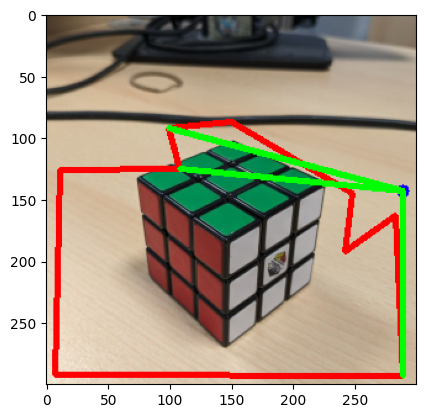

In [86]:
cv2.line(tmp, lowest_vertex, center, (0, 255, 0), thickness = 3)
cv2.line(tmp, sorted_vertices[1][0], center, (0, 255, 0), thickness = 3)
cv2.line(tmp, sorted_vertices[2][0], center, (0, 255, 0), thickness = 3)

plt.imshow(cv2.cvtColor(tmp, cv2.COLOR_BGR2RGB))

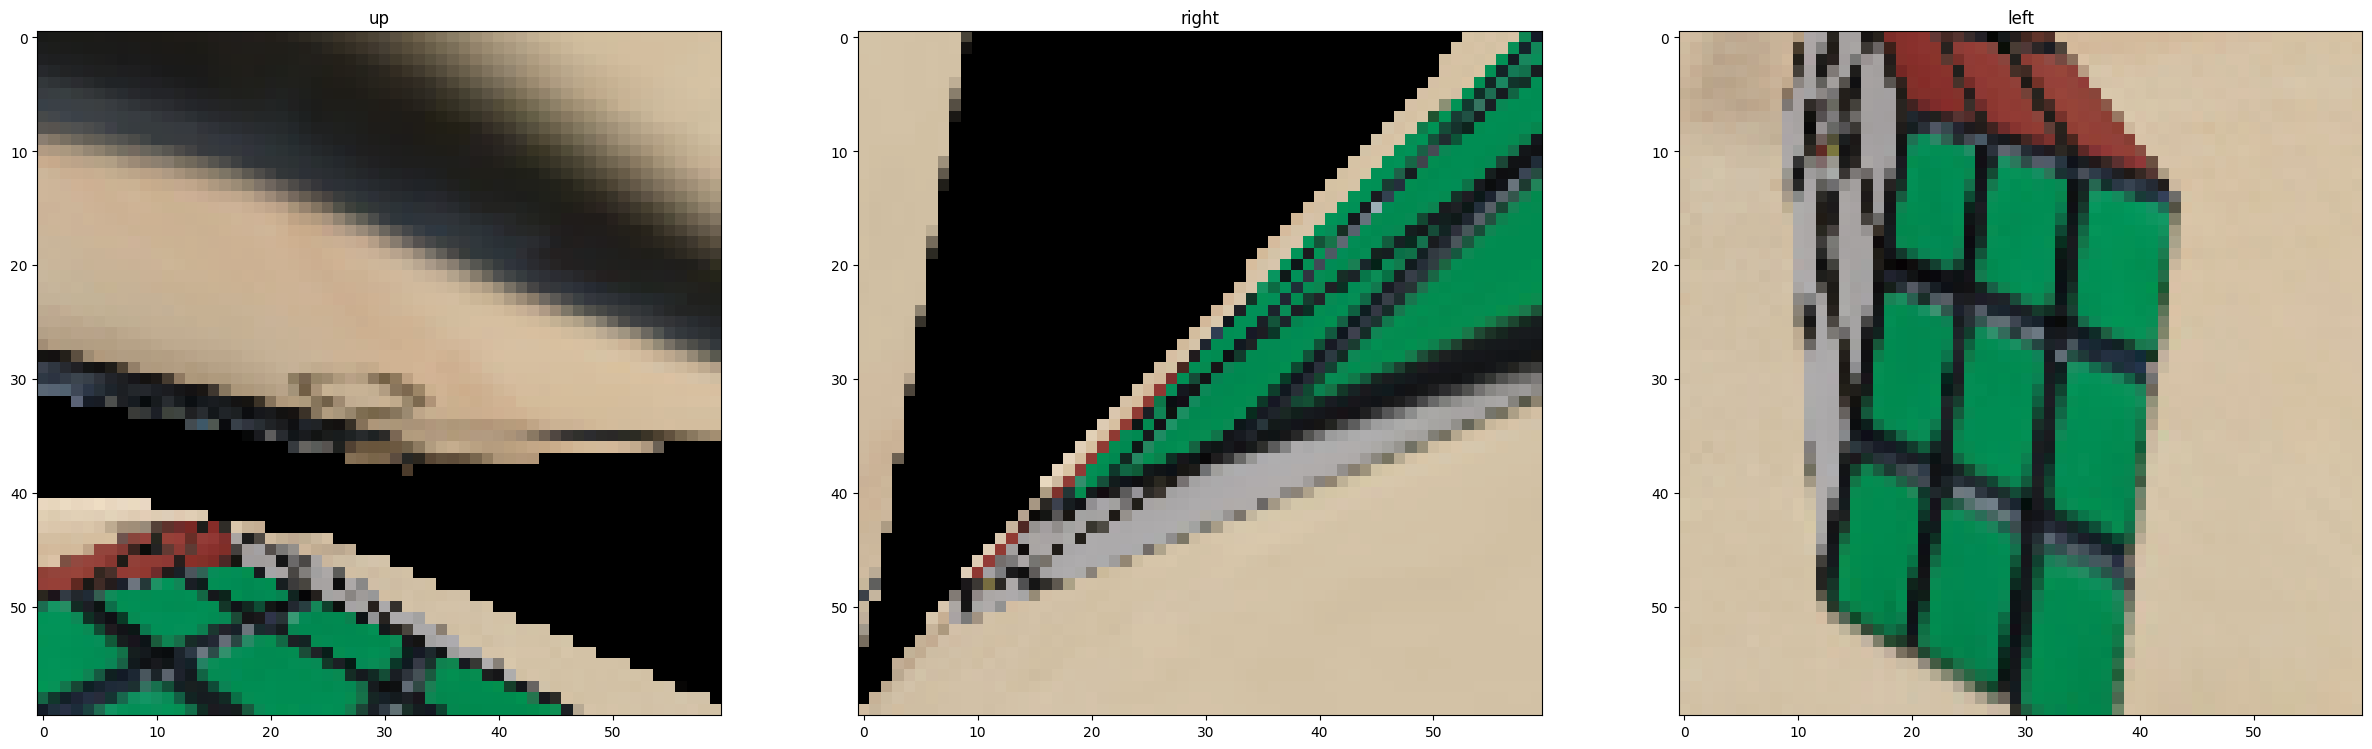

In [87]:
dst_square_size = 60
tmp = cv2.resize(input_image, (300, 300), interpolation = cv2.INTER_AREA)
dst_coordinates = np.array([[0, 0], [dst_square_size - 1, 0], [dst_square_size - 1, dst_square_size - 1], [0, dst_square_size - 1]], dtype=np.float32)

coordinates = np.array([sorted_vertices[0][0], sorted_vertices[1][0], center, sorted_vertices[2][0]], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image1 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))


coordinates = np.array([ center, DX1, DX2, lowest_vertex], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image2 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

coordinates = np.array([ lowest_vertex, SX2, SX1, center], dtype=np.float32)
src_coordinates = np.array(coordinates, dtype=np.float32)
perspective_matrix = cv2.getPerspectiveTransform(src_coordinates, dst_coordinates)
result_image3 = cv2.warpPerspective(tmp, perspective_matrix, (dst_square_size, dst_square_size))

imshow_all(cv2.cvtColor(result_image1, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image2, cv2.COLOR_BGR2RGB),cv2.cvtColor(result_image3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])

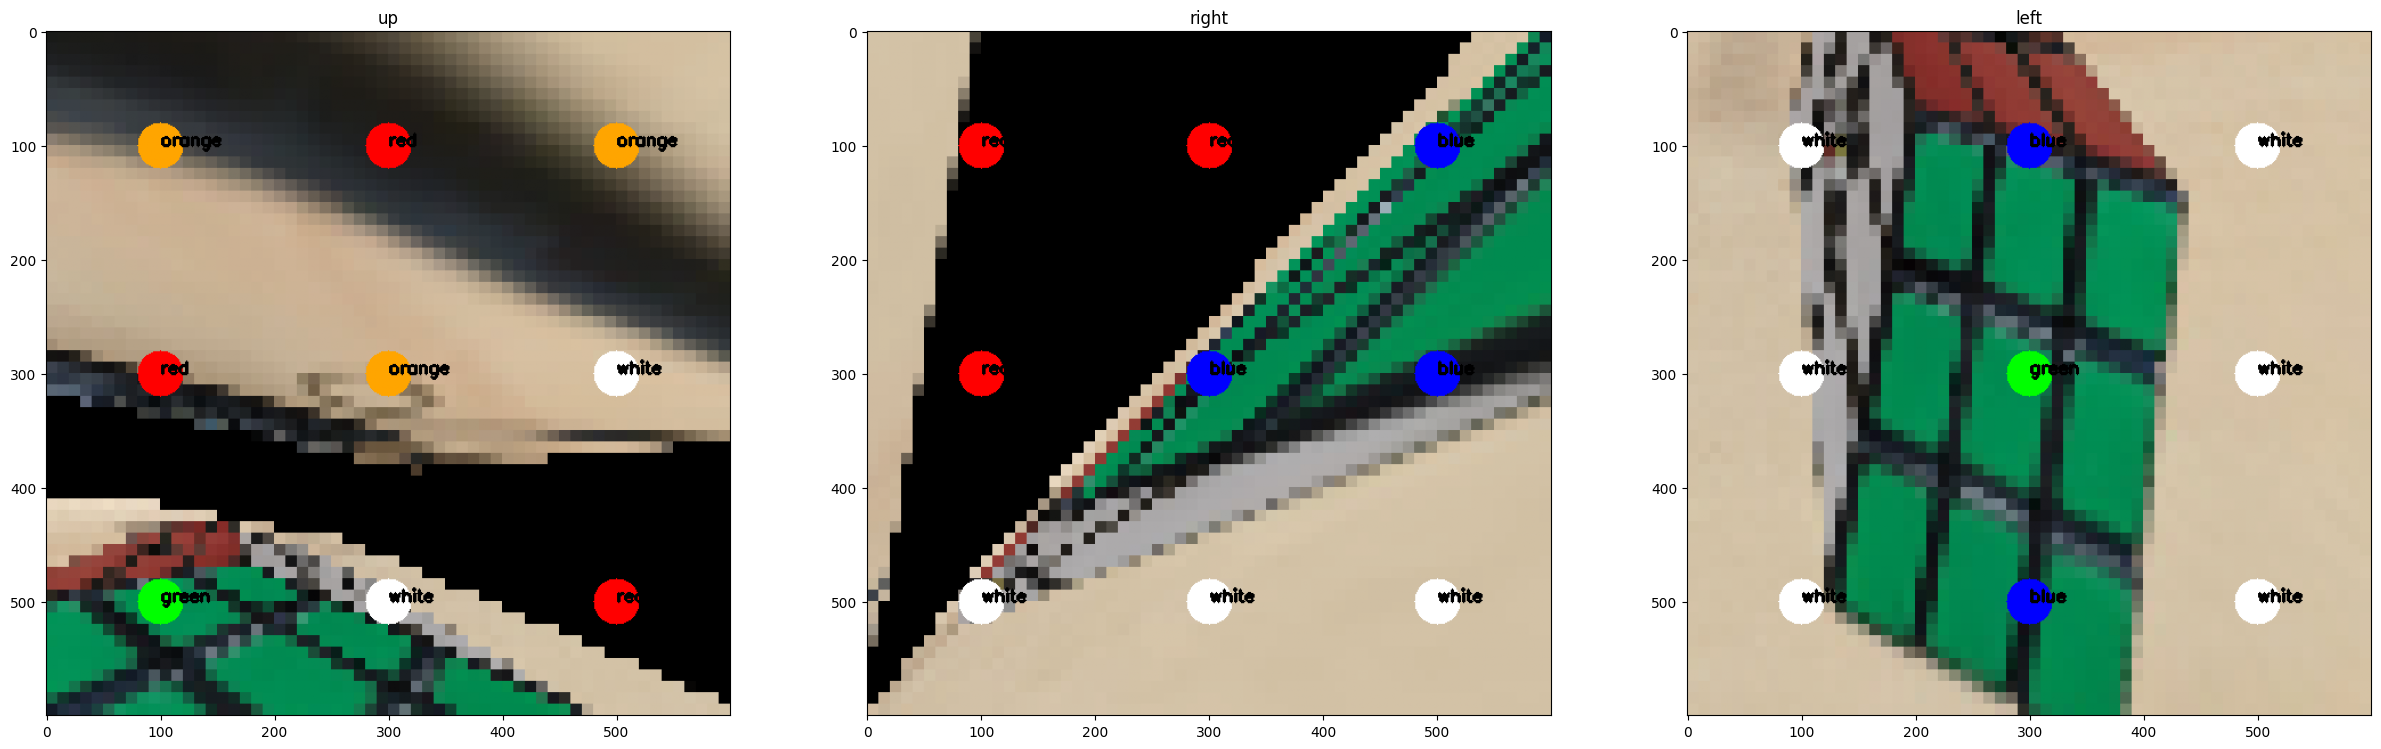

In [88]:

def find_closest_color_vector(color_at_center):
    color_palette = {
        'red': (0, 0, 255),
        'green': (0, 255, 0),
        'blue': (255, 0, 0),
        'white': (255, 255, 255),
        'yellow': (0, 255, 255),
        'orange': (0, 165, 255)
    }
    diff=255*3
    color=("",(0,0,0))
    for i in color_palette.keys():
        tmp_diff = sum((c1 - c2) ** 2 for c1, c2 in zip(color_at_center, color_palette[i])) ** 0.5
        if tmp_diff < diff:
            diff = tmp_diff
            color = (i,color_palette[i])
    return color

tmp1 = cv2.resize(result_image1, (600, 600), interpolation = cv2.INTER_AREA)
tmp2 = cv2.resize(result_image2, (600, 600), interpolation = cv2.INTER_AREA)
tmp3 = cv2.resize(result_image3, (600, 600), interpolation = cv2.INTER_AREA)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        color_at_center = result_image1[j, i]
        closest_color = find_closest_color_vector(color_at_center)
        cv2.circle(tmp1, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp1, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        color_at_center = result_image2[j, i]
        closest_color = find_closest_color_vector(color_at_center)
        cv2.circle(tmp2, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp2, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

for i in np.arange(10,60,20):
    for j in np.arange(10,60,20):
        color_at_center = result_image3[j, i]
        closest_color = find_closest_color_vector(color_at_center)
        cv2.circle(tmp3, (i*10, j*10), 20, closest_color[1], thickness=cv2.FILLED)
        cv2.putText(tmp3, closest_color[0], (i*10, j*10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)

imshow_all(cv2.cvtColor(tmp1, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp2, cv2.COLOR_BGR2RGB),cv2.cvtColor(tmp3, cv2.COLOR_BGR2RGB),titles=["up","right","left"])

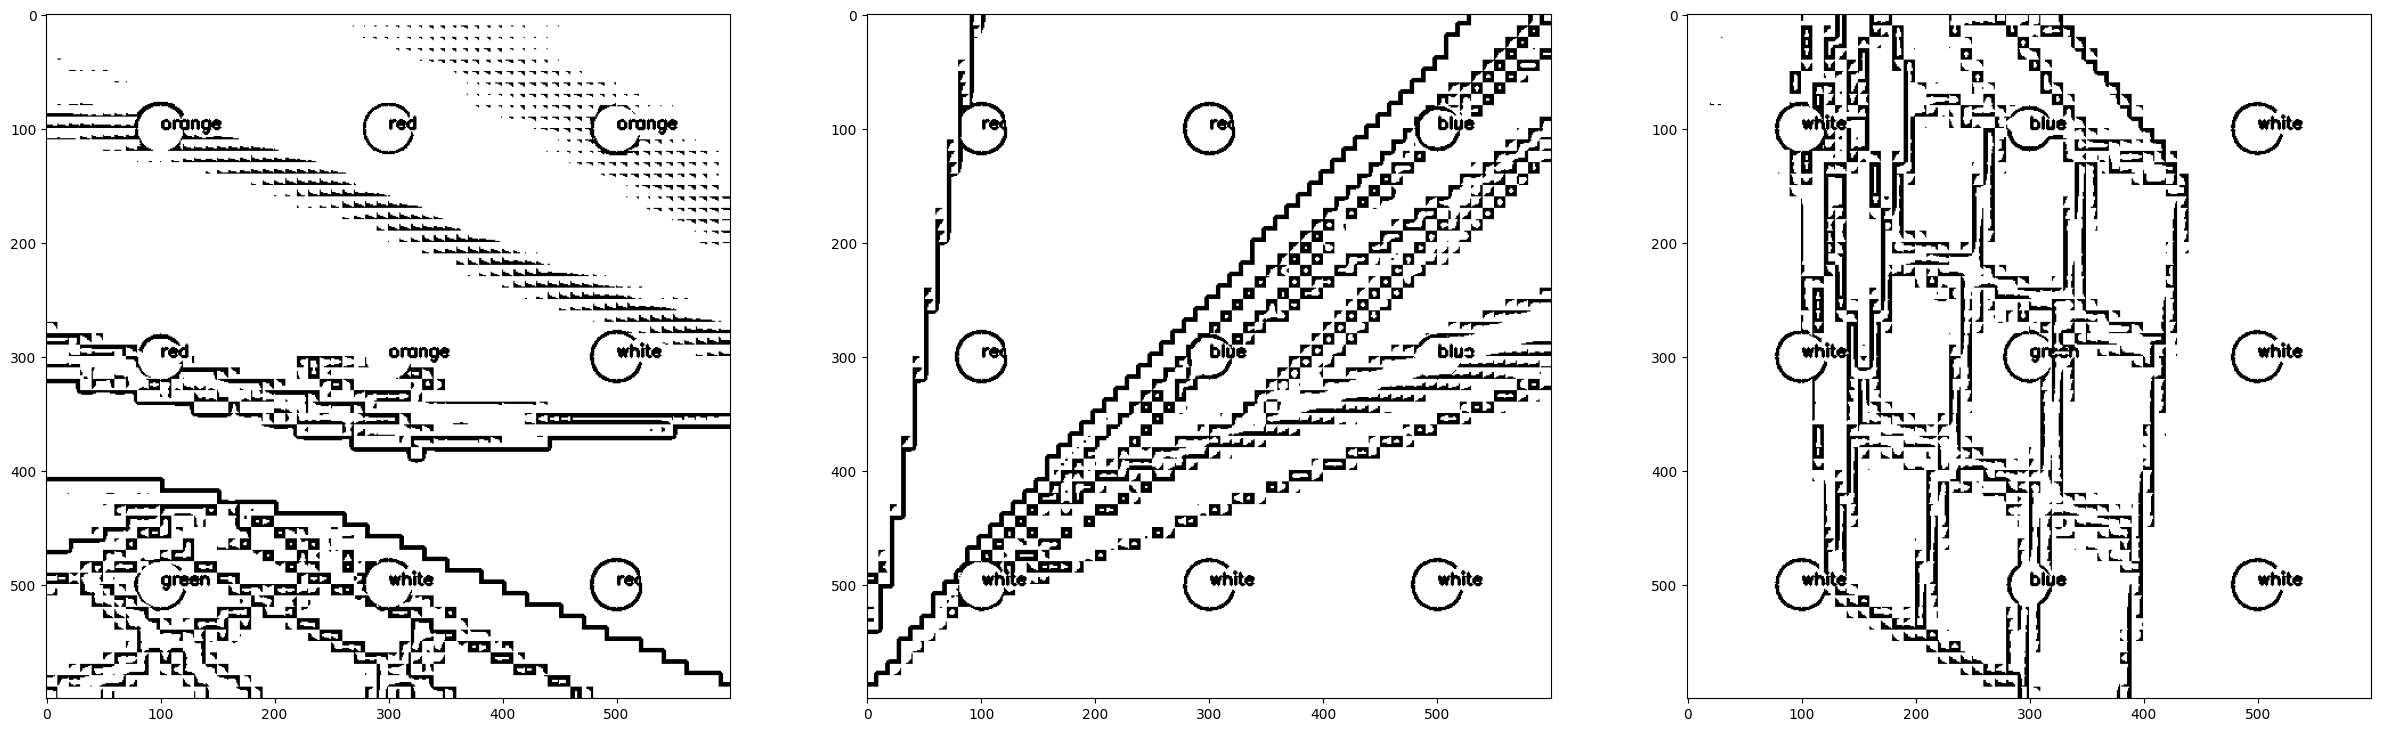

In [89]:
tresh1 = cv2.adaptiveThreshold(cv2.cvtColor(tmp1, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 7)
tresh2 = cv2.adaptiveThreshold(cv2.cvtColor(tmp2, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 7)
tresh3 = cv2.adaptiveThreshold(cv2.cvtColor(tmp3, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 9, 7)
imshow_all(tresh1,tresh2,tresh3)